<h2>Problem Statement : 

Make a Smart Home Assistant, similar to Alexa, which will be capable of turning on and off lights based on the voice commands given by the user. This will be handled by an LLM gathering voice inputs, and using langgraph to ensure the network structure of the house.
<br>#PART 1 : "What should I wear today?"


<br>#PART 2 : Full Smart home


</h2>

<h3>Python playbook

<h4> 1. Figuring out how to make speech-to-text work

In [ ]:
# Python program to translate
# speech to text and text to speech


import speech_recognition as sr
import pyttsx3 

# Initialize the recognizer 
r = sr.Recognizer() 

# Function to convert text to speech
def SpeakText(command):
    
    # Initialize the engine
    engine = pyttsx3.init()
    engine.say(command) 
    engine.runAndWait()
    
    
# Loop infinitely for user to speak

# while(1):    
#     try:
        
#         # use the microphone as source for input.
#         with sr.Microphone() as source2:
            
#             # wait for a second to let the recognizer adjust the energy threshold based on the surrounding noise level 
#             r.adjust_for_ambient_noise(source2, duration=0.2)
            
#             #listens for the user's input 
#             audio2 = r.listen(source2)
            
#             # Using google to recognize audio
#             MyText = r.recognize_google(audio2)
#             MyText = MyText.lower()

#             print("Did you say ", MyText)
#             SpeakText(MyText)
            
#     except sr.RequestError as e:
#         print("Could not request results; {0}".format(e))
        
#     except sr.UnknownValueError:
#         print("unknown error occurred")


<h4>2. That was surprisingly quick. Now lets make an agent. </h4>
<p>The main thing I want to do right now is build a really simple agent, which only has the "Start", "Agent" and "Output" state. The Agent will take in the user's input as speech, and give its own response in an audio output

In [ ]:
from typing import TypedDict, List
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
from langgraph.graph import START, END, StateGraph

class AgentState(TypedDict):
    messages: List[HumanMessage]

llm = ChatOllama(model="qwen2.5:0.5b")

def process_node(state: AgentState) -> AgentState:
    """This node simply sends the user input as a human message to chat ollama llm, and prints its response without recording it in the state"""
    response = llm.invoke(state["messages"])
    print("\nAI: " + response.content)
    return state

graph = StateGraph(AgentState)
graph.add_node("Agent", process_node)
graph.add_edge(START, "Agent")
graph.add_edge("Agent", END)

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
conversation_history = []

def get_voice_input():
    try:
        
        # use the microphone as source for input.
        with sr.Microphone() as source2:
            
            # wait for a second to let the recognizer adjust the energy threshold based on the surrounding noise level 
            r.adjust_for_ambient_noise(source2, duration=0.2)
            
            #listens for the user's input 
            audio2 = r.listen(source2)
            
            # Using google to recognize audio
            user_input = r.recognize_google(audio2)
            user_input = user_input.lower()
            
    except sr.RequestError as e:
        print("Could not request results; {0}".format())
        
    except sr.UnknownValueError:
        print("unknown error occurred")

    return user_input

command =  get_voice_input()

while command != 'exit game':
     
        print("Human: ", command)
        conversation_history.append(HumanMessage(content=command))
        AiResponse = app.invoke({"messages": conversation_history})
        conversation_history = AiResponse["messages"]
        print(f"{AiResponse["messages"]}")
        #SpeakText(AiResponse)
        command = get_voice_input()

Now lets start to work on making our graph a little more complicated. I am thinking of making a room builder node (setup) and a tool node which turns lights on and off

In [ ]:
# from langchain_core.tools import tool

# @tool
# def house_builder(house : map[map]) -> map[map]:
#     """
#     This function updates the house based on the current input text
#     """
#     house.
# def setup_node(state : AgentState)-> AgentState:
#     """This function is used to ask user for their input on how life works"""

#     return state

<h2>#PART 2 : Full Smart home

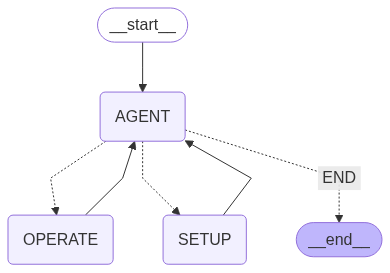

In [6]:
from langgraph.graph import StateGraph, END, START
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from typing import TypedDict, Dict, List, Union
import re

# -------------------------------
# STATE
# -------------------------------

class HomeState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]
    home_config: Dict[str, Dict[str, str]]  # room -> {device -> state}


# -------------------------------
# LLM Node: ChatOllama
# -------------------------------

llm = ChatOllama(model="qwen2.5:0.5b")

def agent_node(state: HomeState) -> HomeState:
    """Invoke the local LLM to generate a response based on current message history."""
    response = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [response], "home_config": state["home_config"]}

# -------------------------------
# Setup Node: Build home configuration
# -------------------------------

def setup_node(state: HomeState) -> HomeState:
    """
    Parse the user's input to initialize room-device configuration.

    Extracts device types and quantities (e.g., '3 lights in the living room') 
    and stores them in a nested map with each device initialized to OFF.
    """
    last_msg = state["messages"][-1]
    if not isinstance(last_msg, HumanMessage):
        return state

    text = last_msg.content.lower()
    room_config = {}
    match = re.findall(r'(\d+)\s+(lights?|fans?|acs?)\s+in\s+the\s+([\w\s]+)', text)

    for count_str, device_type, room in match:
        count = int(count_str)
        room = room.strip()
        room_key = room.lower()
        if room_key not in state["home_config"]:
            state["home_config"][room_key] = {}

        for i in range(1, count + 1):
            device_name = f"{device_type.rstrip('s')}{i}"
            state["home_config"][room_key][device_name] = "OFF"

    return state

# -------------------------------
# Operation Node: Turn devices ON/OFF
# -------------------------------

def operation_node(state: HomeState) -> HomeState:
    """
    Modify the ON/OFF status of devices in specific rooms based on user input.

    Identifies the room and device types mentioned in the message and updates 
    their power state accordingly within the stored home configuration.
    """
    last_msg = state["messages"][-1]
    if not isinstance(last_msg, HumanMessage):
        return state

    text = last_msg.content.lower()
    room_keys = list(state["home_config"].keys())

    for room in room_keys:
        if room in text:
            for device in list(state["home_config"][room].keys()):
                if device.startswith("light") and "light" in text:
                    if "on" in text:
                        state["home_config"][room][device] = "ON"
                    elif "off" in text:
                        state["home_config"][room][device] = "OFF"
                elif device.startswith("fan") and "fan" in text:
                    if "on" in text:
                        state["home_config"][room][device] = "ON"
                    elif "off" in text:
                        state["home_config"][room][device] = "OFF"
                elif device.startswith("ac") and "ac" in text:
                    if "on" in text:
                        state["home_config"][room][device] = "ON"
                    elif "off" in text:
                        state["home_config"][room][device] = "OFF"
    return state

# -------------------------------
# Router Node: Decide next step
# -------------------------------

def router_node(state: HomeState) -> str:
    last_msg = state["messages"][-1]
    if not isinstance(last_msg, HumanMessage):
        return "END"

    text = last_msg.content.lower()
    if "i have" in text or "there are" in text:
        return "SETUP"
    elif "turn on" in text or "turn off" in text:
        return "OPERATE"
    else:
        return "END"

# -------------------------------
# Graph Definition
# -------------------------------

graph = StateGraph(HomeState)

graph.add_node("AGENT", agent_node)
graph.add_node("SETUP", setup_node)
graph.add_node("OPERATE", operation_node)


# Transitions
graph.add_edge(START, "AGENT")
graph.add_conditional_edges("AGENT", router_node, {
    "SETUP": "SETUP",
    "OPERATE": "OPERATE",
    "END": END
})
graph.add_edge("SETUP", "AGENT")
graph.add_edge("OPERATE", "AGENT")

app = graph.compile()


from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [10]:
# -------------------------------
# Run Loop
# -------------------------------

if __name__ == "__main__":
    state: HomeState = {
        "messages": [],
        "home_config": {}
    }

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            break

        state["messages"].append(HumanMessage(content=user_input))
        state = app.invoke(state)
        print(state)
        print("\nUpdated Home Configuration:")
        for room, devices in state["home_config"].items():
            print(f"{room.title()}:")
            for device, status in devices.items():
                print(f"  {device}: {status}")
        print()

{'messages': [HumanMessage(content='Yooo', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How can I assist you today? If you have any questions or need help with something specific, feel free to ask.', additional_kwargs={}, response_metadata={'model': 'qwen2.5:0.5b', 'created_at': '2025-06-15T01:55:10.0387618Z', 'done': True, 'done_reason': 'stop', 'total_duration': 330983100, 'load_duration': 12981000, 'prompt_eval_count': 31, 'prompt_eval_duration': 23461100, 'eval_count': 27, 'eval_duration': 294016900, 'model_name': 'qwen2.5:0.5b'}, id='run--4f7fab26-0cfa-4a08-bc87-da7b1930b7fc-0', usage_metadata={'input_tokens': 31, 'output_tokens': 27, 'total_tokens': 58})], 'home_config': {}}

Updated Home Configuration:

{'messages': [HumanMessage(content='Yooo', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How can I assist you today? If you have any questions or need help with something specific, feel free to ask.', additional_kwargs={}, respon